In [323]:
import numpy as np
import matplotlib.pyplot as plt

def coinciding_states(eph1, eph2): 
    '''
    Return the states in ephemeris eph1 that have the same time as states in ephemeris eph2
    '''
    
    _, indices, _  = np.intersect1d(eph1[:,0], eph2[:,0], assume_unique = True, return_indices = True) 
    
    return eph1[indices]


def find_settle_times(data, thresh = np.deg2rad(0.1)): 
    '''
    Return the settling time of a controller time series. 
    data: ephemeris
    '''
    time = data[:,0]
    settling_times = np.zeros(3)
    
    for i in range(1, 4):
        settling_time_index = np.where((np.abs(data[:,i]) < thresh) == False)[0][-1]
        settling_times[i-1] = time[settling_time_index + 1]
        
    return np.max(settling_times) 

# Data on orbit
mu = 3.986004418e14
a = 6371e3 + 700e3
period = 2 * np.pi * np.sqrt(a**3/mu)
n = 2 * np.pi / period



### Importing simulations

In [324]:
class Simulation:
    
    def __init__(self, CASE_PATH, state_history_m = True, control_torque = True, estimations = True):
        
        self.state_history = np.loadtxt(CASE_PATH + 'state_history.dat')
        
        if state_history_m:
            self.state_history_m = np.loadtxt(CASE_PATH + 'measurements.dat')
            
        if control_torque:
            self.control_torque = np.loadtxt(CASE_PATH + 'control_torque.dat')
            
        if estimations: 
            self.state_estimations = np.loadtxt(CASE_PATH + 'state_history_e.dat')
            self.bias_estimations = np.loadtxt(CASE_PATH + 'bias_history_e.dat')
            self.covariance_estimations = np.load(CASE_PATH + 'covariance_history_e.npy') 

            
# Include the optimisation effort attempts
pnm_paths = [f'output/Q8/r2_10-{i}/' for i in range(5, 19)]
Q8_r2 = []
for i, path in enumerate(pnm_paths): 
    Q8_r2.append(Simulation(path))

# Old simulations for comparison
Q3_PATH = 'output/Q3/'
Q4_PATH = 'output/Q4/control/'

Q3 = Simulation(Q3_PATH) 
Q4 = Simulation(Q4_PATH) 

### Opstimisation of the process noise matrix

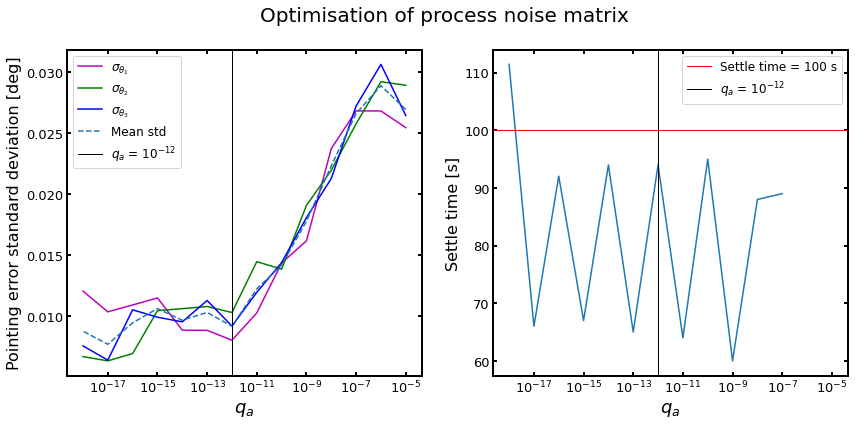

In [325]:
r2s = np.geomspace(1e-5, 1e-18, 14)

stds = np.zeros((len(Q8_r2), 3)) 
settle_times = np.zeros(len(Q8_r2))

for j, simulation in enumerate(Q8_r2): 
    for i in range(3): 
        settle_time = find_settle_times(simulation.state_history)
        settle_times[j] = settle_time
        stds[j, i] = np.std(np.rad2deg(simulation.state_history[simulation.state_history[:,0] > settle_time][:,i+1]))

r2s = np.geomspace(1e-5, 1e-18, 14)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6), sharex = True)
colors = ['m', 'g', 'b']
fig.suptitle("Optimisation of process noise matrix", fontsize = 20)

for i in range(3):
    ax1.plot(r2s, stds[:,i], color = colors[i], label = r"$\sigma_{\theta_%i}$" %(i+1))

ax1.plot(r2s[:], np.mean(stds[:], axis=1), linestyle = '--', label = "Mean std")
ax1.set_ylabel("Pointing error standard deviation [deg]", fontsize = 16)
               
ax2.plot(r2s[2:], settle_times[2:])
ax2.axhline(100, color = 'r', linewidth = 1, label = "Settle time = 100 s")
ax2.set_ylabel("Settle time [s]", fontsize = 16)

for ax in [ax1, ax2]:
    ax.set_xlabel("$q_a$", fontsize = 18)
    ax.set_xscale("log")
    ax.axvline(1e-12, color = 'k', linewidth = 1, label = "$q_a$ = 10$^{-12}$")
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(labelsize=13)
    ax.tick_params(axis="both",direction="in",which="both", length=4, width = 2)
    ax.tick_params(bottom=True, top=True, left=True, right=True)
    ax.legend(fontsize = 12)

### Plotting the time series for the winning $q_a = 10^{-12}$

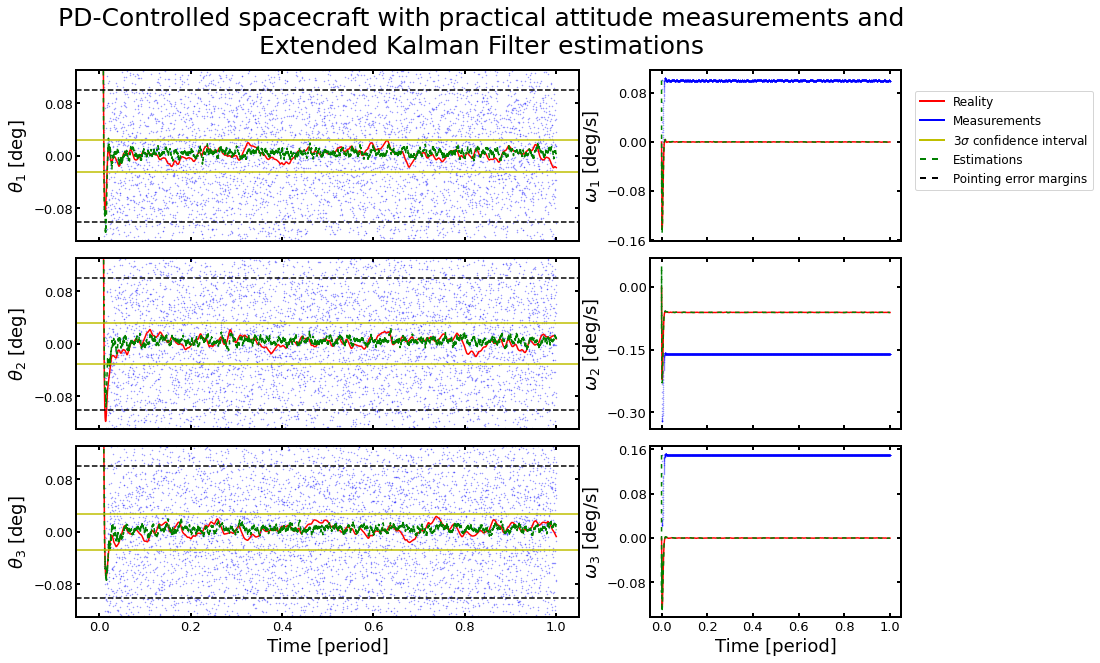

In [326]:
simulation = Q8_r2[7] # the one with q_a = 1e-12

labels = [r"$\theta_1$ [deg]", r"$\theta_2$ [deg]", r"$\theta_3$ [deg]",
          "$\omega_1$ [deg/s]", "$\omega_2$ [deg/s]", "$\omega_3$ [deg/s]"]

fig, axes = plt.subplots(3, 2, figsize = (13, 9), sharex = True, gridspec_kw={'width_ratios':[2,1]})
fig.tight_layout(pad=4)
fig.suptitle("PD-Controlled spacecraft with practical attitude measurements and\nExtended Kalman Filter estimations", fontsize = 25, y = 1.03)
fig.subplots_adjust(hspace= 0.1)
axes[2, 0].set_xlabel("Time [period]", fontsize = 18)
axes[2, 1].set_xlabel("Time [period]", fontsize = 18)

settle_time = find_settle_times(simulation.state_history) 

for ax in axes[:,0]:
    #ax.set_xlim(0, 500)
    ax.set_ylim(-0.13, 0.13)
    ax.axhline(-0.1, linestyle = '--', color = 'k', zorder= 1000)
    ax.axhline(0.1, linestyle = '--', color = 'k', zorder = 1000)

# for ax in axes[:,1]:
#     ax.set_ylim(-0.001, 0.001)

for i, ax in enumerate(axes.T.flat): 
    std = np.std(np.rad2deg(simulation.state_history[simulation.state_history[:,0] > settle_time][:,i+1]))
        
    ax.plot(simulation.state_history_m[:,0]/period, np.rad2deg(simulation
                                        .state_history_m[:,1+i]), 'bo', markersize = 0.5, label = "Observation", alpha = 0.4)

    ax.plot(simulation.state_history[:,0]/period, np.rad2deg(simulation
                                    .state_history[:,1+i]), 'r-', markersize = 1)

    ax.plot(simulation.state_estimations[:,0]/period, np.rad2deg(simulation
                                        .state_estimations[:,1+i]), 'g--', dashes = [3, 3], label = "Estimation")
    
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    ax.set_ylabel(labels[i], fontsize = 18)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(labelsize=13)
    ax.tick_params(axis="both",direction="in",which="both", length=4, width = 2)
    ax.tick_params(bottom=True, top=True, left=True, right=True)
    
    if i < 3:
        ax.axhline(3*std, color = 'y')
        ax.axhline(-3*std, color = 'y')

    
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='b', lw=2), 
                Line2D([0], [0], color='y', lw=2),
                Line2D([0], [0], color='g', lw=2, dashes = [3, 3]), 
               Line2D([0], [0], color='k', lw=2, dashes = [3, 3])]

fig.legend(custom_lines, ["Reality", "Measurements", "3$\sigma$ confidence interval", "Estimations", "Pointing error margins"], 
           bbox_to_anchor = (1.16, 0.91), fontsize = 12)

### Plot the zoomed-in time series $q_a = 10^{-12}$

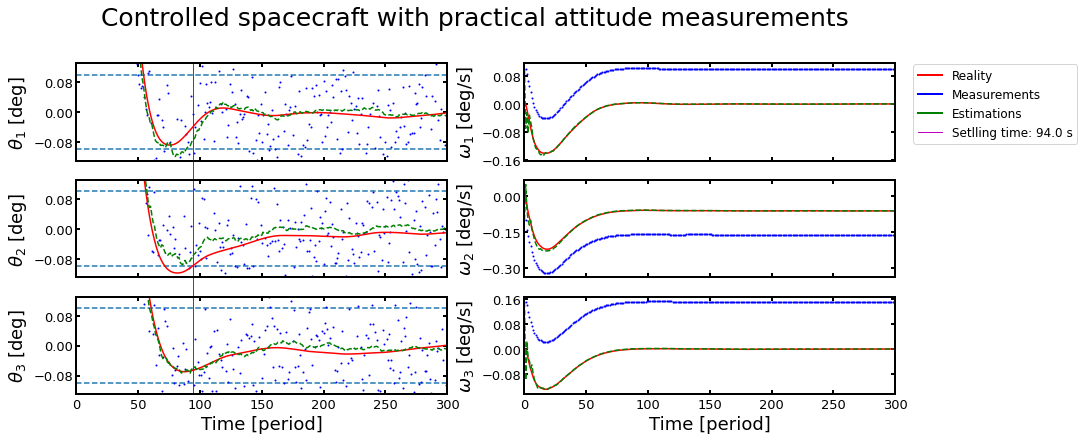

In [327]:
simulation = Q8_r2[7]
settle_time = find_settle_times(simulation.state_history)

labels = [r"$\theta_1$ [deg]", r"$\theta_2$ [deg]", r"$\theta_3$ [deg]",
          "$\omega_1$ [deg/s]", "$\omega_2$ [deg/s]", "$\omega_3$ [deg/s]"]

fig, axes = plt.subplots(3, 2, figsize = (13, 6), sharex = True)
fig.tight_layout(pad=4)
fig.suptitle("Controlled spacecraft with practical attitude measurements", fontsize = 25, y = 1.03)
fig.subplots_adjust(hspace= 0.2)
axes[2, 0].set_xlabel("Time [period]", fontsize = 18)
axes[2, 1].set_xlabel("Time [period]", fontsize = 18)

for ax in axes[:,0]:
    ax.set_xlim(0, 300)
    ax.set_ylim(-0.13, 0.13)
    ax.axhline(-0.1, linestyle = '--')
    ax.axhline(0.1, linestyle = '--')
    
for ax in axes[:-1,0]:
    ax.axvline(settle_time, ymin=-0.4, ymax=1, color = 'm', linewidth = 1, clip_on=False)

axes[2, 0].axvline(settle_time, ymin=0, ymax=1, color = 'm', linewidth = 1, clip_on=False, label = "Setlling time: %.1f" % settle_time)

for i, ax in enumerate(axes.T.flat): 
    ax.plot(simulation.state_history_m[:,0], np.rad2deg(simulation.state_history_m[:,1+i]), 'bo', markersize = 1, label = "Observation")
    ax.plot(simulation.state_history[:,0], np.rad2deg(simulation.state_history[:,1+i]), 'r-', markersize = 1)
    ax.plot(simulation.state_estimations[:,0], np.rad2deg(simulation.state_estimations[:,1+i]), 'g--', label = "Estimation")
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    ax.set_ylabel(labels[i], fontsize = 18)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(labelsize=13)
    ax.tick_params(axis="both",direction="in",which="both", length=4, width = 2)
    ax.tick_params(bottom=True, top=True, left=True, right=True)
    
    
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='b', lw=2), 
                Line2D([0], [0], color='g', lw=2), 
                Line2D([0], [0], color='m', lw=1)]

fig.legend(custom_lines, ["Reality", "Measurements", "Estimations", "Setlling time: %.1f s" % settle_time], 
           bbox_to_anchor = (1.15, 0.91), fontsize = 12)

### Plot distribution of pointing errors Q8 r2 = 10^{-12}

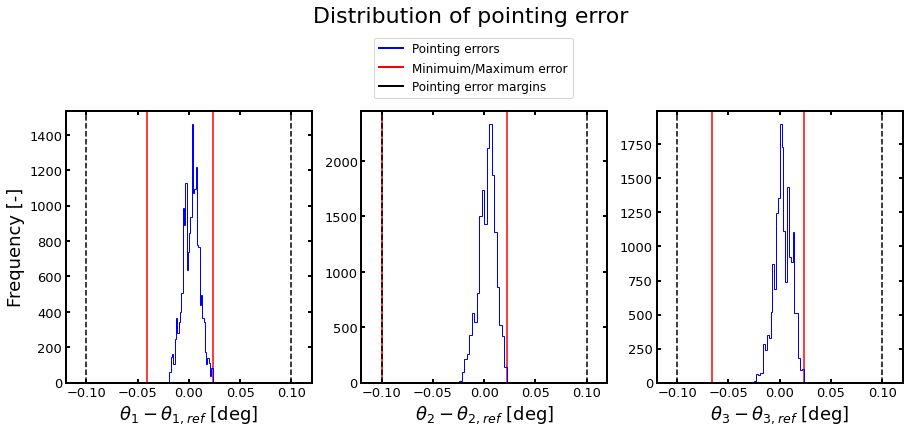

In [328]:
simulations = np.array([Q8_r2[7]])
euler_angles = ["Roll", "Pitch", "Yaw"]
simulation = Q8_r2[7]

#Prepare figure
fig, axes = plt.subplots(1, 3, figsize = (15, 5)) 
fig.suptitle("Distribution of pointing error", fontsize = 22, y = 1.17)

# Iterate over Euler Anglers
for i in range(3): 
    axes[i].hist(np.rad2deg(simulation.state_history[simulation.state_history[:,0] > settle_time][:,i+1]), color = 'b', bins = 50, histtype='step', label = "Estimations")
    axes[i].axvline(np.max(np.rad2deg(simulation.state_history[simulation.state_history[:,0] > settle_time][:,i+1])), color = 'r', label = "Maximum difference", zorder = -1000)
    axes[i].axvline(np.min(np.rad2deg(simulation.state_history[simulation.state_history[:,0] > settle_time][:,i+1])), color = 'r', label = "Minimum difference", zorder = -1000)
    axes[i].axvline(0.1, linestyle= '--', color = 'k', zorder = 1000)
    axes[i].axvline(-0.1, linestyle= '--', color = 'k', zorder = 1000)
    axes[i].set_xlim(-0.12, 0.12)
    axes[i].set_xlabel(r"$\theta_{%i} - \theta_{%i, ref}$ [deg]" % (i+1, i+1), fontsize = 18) 

axes[0].set_ylabel(r"Frequency [-]", fontsize = 18)
for ax in axes:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(labelsize=13)
    ax.tick_params(axis="both",direction="in",which="both", length=4, width = 2)
    ax.tick_params(bottom=True, top=True, left=True, right=True)

custom_lines = [Line2D([0], [0], color='b', lw=2),
                Line2D([0], [0], color='r', lw=2), 
                Line2D([0], [0], color='k', lw=2)]

fig.legend(custom_lines, ["Pointing errors", "Minimuim/Maximum error", "Pointing error margins"], 
           bbox_to_anchor = (0.6, 1.1), fontsize = 12)

### Print performance metrics

In [329]:
slabels = ["Q3", "Q4", "Q8"]
from sklearn.metrics import mean_squared_error


for i, simulation in enumerate([Q3, Q4, Q8]): 
    
    print("Simulation = ", slabels[i]) 
    
    try: 
        settle_time = find_settle_times(simulation.state_history)
    except IndexError: 
        settle_time = 0
        
    print("Settle time = ", settle_time)
    print() 
    
    for j in range(3): 
        
        print("Euler angle = ", j)
        if i ==2: 
            settle_time = 100
            
        euler_angle = np.rad2deg(simulation.state_history[simulation.state_history[:,0] > settle_time][:,i+1])
        MAE = np.mean(np.abs(euler_angle))
        STD = np.std(euler_angle)
        rms = mean_squared_error(euler_angle, np.zeros(len(euler_angle)), squared=False)

        print("3 sigmna = ", 3 * STD)
        print("RMS = ", rms)
    
    print()

Simulation =  Q3
Settle time =  59.24048330935154

Euler angle =  0
3 sigmna =  0.014940556283240128
RMS =  0.006663237809001273
Euler angle =  1
3 sigmna =  0.014940556283240128
RMS =  0.006663237809001273
Euler angle =  2
3 sigmna =  0.014940556283240128
RMS =  0.006663237809001273

Simulation =  Q4
Settle time =  0

Euler angle =  0
3 sigmna =  0.5620641129670787
RMS =  2.05878149687845
Euler angle =  1
3 sigmna =  0.5620641129670787
RMS =  2.05878149687845
Euler angle =  2
3 sigmna =  0.5620641129670787
RMS =  2.05878149687845

Simulation =  Q8
Settle time =  94.0

Euler angle =  0
3 sigmna =  0.026831028378217804
RMS =  0.009366586474674459
Euler angle =  1
3 sigmna =  0.026831028378217804
RMS =  0.009366586474674459
Euler angle =  2
3 sigmna =  0.026831028378217804
RMS =  0.009366586474674459



### Plotting the performance of the EKF (not featured in the report)

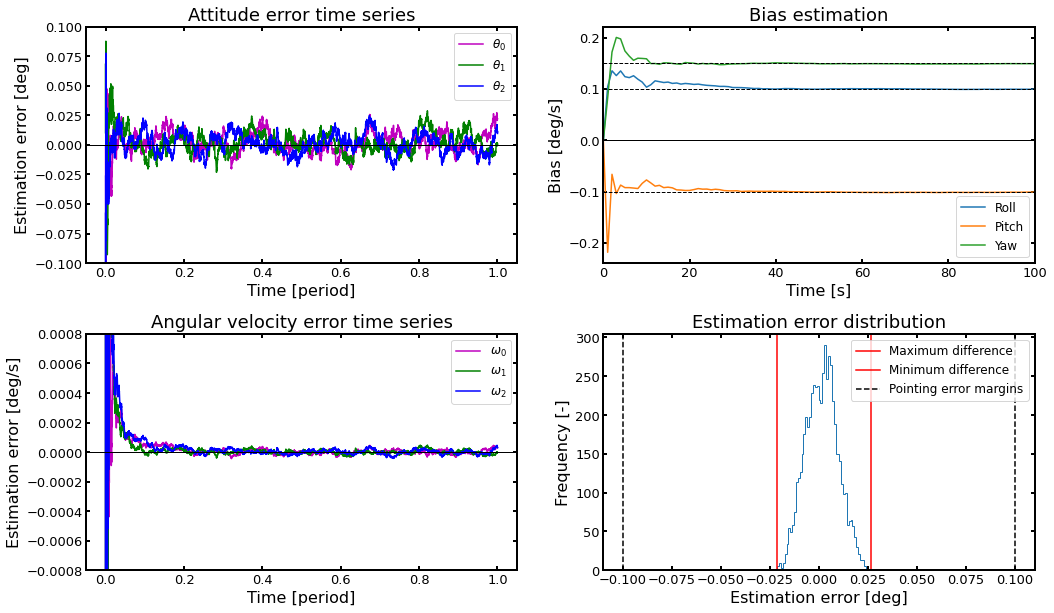

In [330]:
simulation = Q8_r2[7]
real_states_coinciding = coinciding_states(simulation.state_history, simulation.state_estimations)
colors = ['m', 'g', 'b']
fig, axes = plt.subplots(2, 2, figsize = (17, 10))
fig.subplots_adjust(hspace= 0.3)
axes[0,1].set_title("Bias estimation", fontsize = 18)
axes[0,1].plot(S.bias_estimations[:,0], np.rad2deg(S.bias_estimations[:,1]), label = "Roll")
axes[0,1].plot(S.bias_estimations[:,0], np.rad2deg(S.bias_estimations[:,2]), label = "Pitch")
axes[0,1].plot(S.bias_estimations[:,0], np.rad2deg(S.bias_estimations[:,3]), label = "Yaw")

axes[0,1].axhline(0.1, color= 'k', linestyle = '--', linewidth = 1)
axes[0,1].axhline(-0.1, color= 'k', linestyle = '--', linewidth = 1)
axes[0,1].axhline(0.15, color= 'k', linestyle = '--', linewidth = 1) 

axes[1,1].set_title("Estimation error distribution", fontsize = 18)
axes[1,1].hist(diffs[real_states_coinciding[:,0] > find_settle_times(simulation.state_history)], bins = 50, histtype='step')
axes[1,1].axvline(np.max(diffs[real_states_coinciding[:,0] > find_settle_times(simulation.state_history)]), color = 'r', label = "Maximum difference")
axes[1,1].axvline(np.min(diffs[real_states_coinciding[:,0] > find_settle_times(simulation.state_history)]), color = 'r', label = "Minimum difference")
axes[1,1].axvline(0.1, linestyle= '--', color = 'k', label = "Pointing error margins")
axes[1,1].axvline(-0.1, linestyle= '--', color = 'k')

axes[0,0].set_title("Attitude error time series", fontsize = 18)
axes[1,0].set_title("Angular velocity error time series", fontsize = 18)

for i in range(3):
    diffs = np.rad2deg(simulation.state_estimations[:,i+4] - real_states_coinciding[:,i+4])
    axes[1,0].plot(simulation.state_estimations[:,0]/period, diffs,  color = colors[i], label = f"$\omega_{i}$")
    diffs = np.rad2deg(simulation.state_estimations[:,i+1] - real_states_coinciding[:,i+1])
    axes[0,0].plot(simulation.state_estimations[:,0]/period, diffs, color = colors[i], label = r"$\theta_{%i}$" % i)

    
axes[0,1].set_xlim(0, 100)

axes[1,0].set_ylim(-0.0008, 0.0008)

axes[0,0].set_ylim(-0.1, 0.1)

axes[0,0].set_xlabel("Time [period]", fontsize = 16)
axes[0,0].set_ylabel("Estimation error [deg]", fontsize = 16)

axes[1,0].set_xlabel("Time [period]", fontsize = 16)
axes[1,0].set_ylabel("Estimation error [deg/s]", fontsize = 16)

axes[0,1].set_xlabel("Time [s]", fontsize = 16)
axes[0,1].set_ylabel("Bias [deg/s]", fontsize = 16)

axes[1,1].set_xlabel("Estimation error [deg]", fontsize = 16)
axes[1,1].set_ylabel("Frequency [-]", fontsize = 16)

for ax in axes.flat: 
    ax.axhline(0, color = 'k', linewidth = 1)
    ax.legend(fontsize = 12)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(labelsize=13)
    ax.tick_params(axis="both",direction="in",which="both", length=4, width = 2)
    ax.tick_params(bottom=True, top=True, left=True, right=True)